Milo @Berkeley - May 2019

### Goal:
To find AIA-FeXVIII brightenings on Athiray region using Kobelski method.

## Kobelski Method:

**Kobelski, McKenzie and Donachie [2014]**:  <br>
http://iopscience.iop.org/article/10.1088/0004-637X/786/2/82/pdf <br>
The detection algorithm is based on the method of Berghmans & Clette (1999), which looks for enhancements in the observed flux on a pixel by pixel basis. Enhancements in neighboring pixels are then grouped together and defined as an ARTB. <br><br/>

This approach involves subtracting a running mean from the time profile of brightness in each pixel, then looking for residuals larger than a predefined threshold, typically three standard deviations.<br><br/>

After calibration and co-alignment, a running mean of the image stack is created by applying a temporal boxcar smoothing of width $\omega_{rm}$. This temporally smoothed version of the image is then subtracted from the original image, resulting in a residual with the mean removed.
The next step is to determine the standard deviation of the light curves for each pixel in the image stack, which is used to make a ratio between the residual and the standard deviation. The “brightest” pixel in this ratio is determined to be an ARTB as long as it is greater than $q_D$, the detection threshold. All pixels in the ratio array that are larger than a second threshold, $q_C$ , are then checked for connectivity to the $q_D$ point.<br><br/>
A good $\omega_{rm}$ to start is $\approx 10$ min.

Athiray considered Target1 Pos 2 - 19:13:47 to 19:14:25 for this study, where microflare-1 was mostly on-axis. For variance calculation in Fe18 map use this time interval. Consider the region in the map around microflare-1 say xrange = [-45,105], yrange=[-295,-145]. 

## Imports:

In [1]:
import glob
from sunpy.map import Map
from sunpy.time import TimeRange
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)
import numpy as np
import ipywidgets as widgets
%matplotlib inline
from ndcube import NDCube, NDCubeSequence
from sunpy import cm

## FOXSI2 Definitions:

In [2]:
Ftarget = {'cen1_pos0':(359.0, -431.0), # arcsec
           'cen1_pos1':(-1.0, -431.0),
           'cen1_pos2':(-1.0, -251.0),
           'cen2_pos0':(-1.0, -281.0),
           'cen2_pos1':(-390.0, -281.0),
           'cen3_pos0':(1210.5, -431.5),
           'cen3_pos1':(850.0, -431.5),
           'cen3_pos2':(850.0, -251.0),
           'cen4':(200.0, 750.0),
           'cen5':(0.0, -251.0),
           'cen_Iris':(11,-260),
           'athiray':(30,-220)}
Ftimes = {'cen1_pos0': TimeRange(['2014-12-11 19:12:42', '2014-12-11 19:13:14.3']),
            'cen1_pos1':TimeRange(['2014-12-11 19:13:18','2014-12-11 19:13:42.6']),
            'cen1_pos2':TimeRange(['2014-12-11 19:13:46.5','2014-12-11 19:14:25']),
            'cen2_pos0':TimeRange(['2014-12-11 19:14:29','2014-12-11 19:14:39.6']),
            'cen2_pos1':TimeRange(['2014-12-11 19:14:44','2014-12-11 19:15:36.7']),
            'cen3_pos0':TimeRange(['2014-12-11 19:15:40.6','2014-12-11 19:16:07.2']),
            'cen3_pos1':TimeRange(['2014-12-11 19:16:11','2014-12-11 19:16:30.1']),
            'cen3_pos2':TimeRange(['2014-12-11 19:16:34','2014-12-11 19:17:09.2']),
            'cen4':TimeRange(['2014-12-11 19:17:13.5','2014-12-11 19:18:46.2']),
            'cen5':TimeRange(['2014-12-11 19:18:50.5','2014-12-11 19:19:23.2']),
            't_shtr':TimeRange(['2014-12-11 19:18:18','2014-12-11 19:18:22']),
            'Iris_Obs':TimeRange(['2014-12-11 19:12:22','2014-12-11 19:39:01'])}
fov = (1000,1000) # arcsec
athirayfov = [150,150] #arcsec

## Reading AIA Data:

In [121]:
data_dir = '/Volumes/Pandora/FOXSI/AIA/'
str_indices = {'94':'', '131':'', '171':'', '193':'', '211':'', '304':'', '335':'', '1600':'', '1700':''}
file_list = {}
for key in str_indices:
    file_list.update({key: glob.glob(data_dir + '*' + key + '*.fits')})
    file_list[key]=sorted(file_list[key])

In [125]:
F_AIA094 = file_list['94']
F_AIA171 = file_list['171']
F_AIA211 = file_list['211']

#F_AIA171 = file_list['171'][52:83]
#F_AIA211 = file_list['211'][56:87]
mapsFe18 = []
for f094, f171, f211 in zip(F_AIA094,F_AIA171,F_AIA211):
    m094  = Map(f094)
    m171  = Map(f171)
    m211  = Map(f211)
    mFe18 = Map(f171)
    mFe18.data[:] = m094.data[:] - m211.data[:]/120 - m171.data[:]/450    
    ## Co-rotating maps:
    top_right =   SkyCoord((Ftarget['athiray'][0] + athirayfov[0]/2) * u.arcsec, 
                           (Ftarget['athiray'][1] + athirayfov[1]/2) * u.arcsec, frame=mFe18.coordinate_frame)
    bottom_left = SkyCoord((Ftarget['athiray'][0] - athirayfov[0]/2) * u.arcsec, 
                           (Ftarget['athiray'][1] - athirayfov[1]/2) * u.arcsec,frame=mFe18.coordinate_frame)
    submap = mFe18.submap(bottom_left, top_right)
    mapsFe18.append(submap)

## FeXVIII Movie

In [236]:
def allfov(t):
    fig, ax = plt.subplots(figsize=(10,10));
    mapsFe18[t].plot_settings['cmap'] = cm.cm.sdoaia171.reversed()
    mapsFe18[t].plot(vmin=15,vmax=120,title='FeXVIII    '+F_AIA171[t][41:63])
    rect = patches.Rectangle((-45,-295),150,150,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.colorbar()

In [237]:
l = 12
widgets.interact(allfov, t=(68-l,72+l));

interactive(children=(IntSlider(value=70, description='t', max=84, min=56), Output()), _dom_classes=('widget-i…

## Run differences Athiray's FOV:

In [228]:
import copy
diff = copy.deepcopy(mapsFe18)
for d in range (1,len(diff[1:])):
    diff[d].data[:] = mapsFe18[d].data[:] - mapsFe18[d-1].data[:]

In [231]:
def difffov(t):
    fig, ax = plt.subplots(figsize=(10,10));
    diff[t].plot(cmap='viridis',title='FeXVIII    '+F_AIA171[t][41:63],vmin=-10,vmax=10)
    rect = patches.Rectangle((-45,-295),150,150,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.colorbar()
## Run Widget:
l = 12
widgets.interact(difffov, t=(68-l,72+l));

interactive(children=(IntSlider(value=70, description='t', max=84, min=56), Output()), _dom_classes=('widget-i…

## Mean, STD, neighbours functions:

In [232]:
def mean(cmaps):
    """
    Calculate the average of the data array.
    """
    _meta = []
    for i, m in enumerate(cmaps):
        _meta.append(m.meta)
    data = np.zeros((cmaps[0].data.shape[0], cmaps[0].data.shape[1], len(cmaps)), dtype=cmaps[0].data.dtype)
    for i, m in enumerate(cmaps):
        data[:, :, i] = m.data
    return Map(np.mean(data, axis=2), _meta[1])

def std(cmaps):
    """
    Calculate the standard deviation of the data array.
    """
    _meta = []
    for i, m in enumerate(cmaps):
        _meta.append(m.meta)
    data = np.zeros((cmaps[0].data.shape[0], cmaps[0].data.shape[1], len(cmaps)), dtype=cmaps[0].data.dtype)
    for i, m in enumerate(cmaps):
        data[:, :, i] = m.data
    return Map(np.std(data, axis=2), _meta[1])

def get_neighbours2(data, cell):
    """Find the neighbouring values for the cell in the 'data' list
           data : A homogenous 2d list (i.e. all rows are the same length)
       cell : A 2-tuple with row, column in order
    """
    neighbours = []
    row, col = cell[0], cell[1]
    row_max = len(data) # Get upper bound of row length
    col_max = len(data[0])
 
    return [data[row_d + row][col_d + col]
    for col_d in [-1,0,1]
        if (0 <= (col_d + col) < col_max) or (col_d == 0 and row_d==0)
    for row_d in [-1,0,1]
    if 0 <= (row_d + row) < row_max ]

## Check this since I have to load more data than the one I aldready have

In [238]:
l = 12
wrm = 44 # (int) time width - 44 frames is equivalent to 10 min
qd = -4
qc = -3
smap,bright_maps,maps_qd,maps_qc = [],[],[],[]

for i in range(68-l,72+l):
    maps_i = mapsFe18[i-wrm//2:i+wrm//2]   # Takes wrm 'frames' around frame i
    mean_i = mean(maps_i) # Calculates the mean around i
    residual_i = (mapsFe18[i].data - mean_i.data) # residual data
    std_i = std(maps_i).data # STD 
    data_qd = (residual_i/std_i)
    data_qd[np.where((residual_i/std_i)>=qd)] = 0.0 # Data under QD TH
    data_qc = (residual_i/std_i)
    data_qc[np.where((residual_i/std_i)>=qc)] = 0.0 # Data under QC TH
    smap.append(mapsFe18[i])
    maps_qd.append(Map(data_qd, mapsFe18[i].meta))
    maps_qc.append(Map(data_qc, mapsFe18[i].meta))
    bright_maps.append(Map(residual_i/std_i, mapsFe18[i].meta))

## Plotting one of the maps with the qd and qc parameters as an example

In [251]:
def allfov(i):
    '''Plotting'''
    plt.figure(figsize=(16,16))
    plt.subplot(2,2,1)
    smap[i].plot_settings['cmap'] = cm.cm.sdoaia171.reversed()
    smap[i].plot(vmin=20)
    plt.title('Raw data'+smap[i].name[-20:],fontsize=18);plt.colorbar()
    plt.subplot(2,2,2)
    bright_maps[i].plot(vmin=-2,vmax=2)
    plt.title('Residual / std '+bright_maps[i].name[-20:],fontsize=18);plt.colorbar()
    plt.subplot(2,2,3)
    maps_qd[i].plot()
    plt.title('Residual / std / qd '+maps_qd[i].name[-20:],fontsize=16);plt.colorbar()
    plt.subplot(2,2,4)
    maps_qc[i].plot()
    plt.title('Residual / std / qc '+maps_qc[i].name[-20:],fontsize=16);plt.colorbar()
    plt.show()

In [252]:
widgets.interact(allfov, i=(0,len(smap)-1));

interactive(children=(IntSlider(value=13, description='i', max=27), Output()), _dom_classes=('widget-interact'…

## Test

In [14]:
file_list['171'][72]

'/Volumes/Pandora/FOXSI/AIA/aia_lev1_171a_2014_12_11t19_14_35_34z_image_lev1.fits'

In [ ]:
19:13:47 to 19:14:25

In [12]:
l = 12
file_list['171'][68-l:72+l]

['/Volumes/Pandora/FOXSI/AIA/aia_lev1_171a_2014_12_11t19_11_23_34z_image_lev1.fits',
 '/Volumes/Pandora/FOXSI/AIA/aia_lev1_171a_2014_12_11t19_11_35_34z_image_lev1.fits',
 '/Volumes/Pandora/FOXSI/AIA/aia_lev1_171a_2014_12_11t19_11_47_34z_image_lev1.fits',
 '/Volumes/Pandora/FOXSI/AIA/aia_lev1_171a_2014_12_11t19_11_59_34z_image_lev1.fits',
 '/Volumes/Pandora/FOXSI/AIA/aia_lev1_171a_2014_12_11t19_12_11_34z_image_lev1.fits',
 '/Volumes/Pandora/FOXSI/AIA/aia_lev1_171a_2014_12_11t19_12_23_34z_image_lev1.fits',
 '/Volumes/Pandora/FOXSI/AIA/aia_lev1_171a_2014_12_11t19_12_35_34z_image_lev1.fits',
 '/Volumes/Pandora/FOXSI/AIA/aia_lev1_171a_2014_12_11t19_12_47_34z_image_lev1.fits',
 '/Volumes/Pandora/FOXSI/AIA/aia_lev1_171a_2014_12_11t19_12_59_34z_image_lev1.fits',
 '/Volumes/Pandora/FOXSI/AIA/aia_lev1_171a_2014_12_11t19_13_11_34z_image_lev1.fits',
 '/Volumes/Pandora/FOXSI/AIA/aia_lev1_171a_2014_12_11t19_13_23_34z_image_lev1.fits',
 '/Volumes/Pandora/FOXSI/AIA/aia_lev1_171a_2014_12_11t19_13_35_34

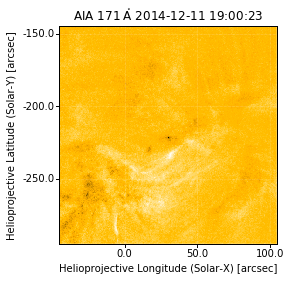

In [242]:
mapsFe18[1].plot()